# VGP の使い方　正値の解に限定する

## Library

In [1]:
import numpy as np
import GPflow
%matplotlib inline 
import matplotlib.pyplot as plt

# 隠れ関数が正である人工データ

In [2]:
rng = np.random.RandomState(0)

In [3]:
X1 = np.linspace(0,6,50).reshape(-1,1)
f = np.sin(X1)**2.0
Y1 = f + rng.randn(*X1.shape)*0.1

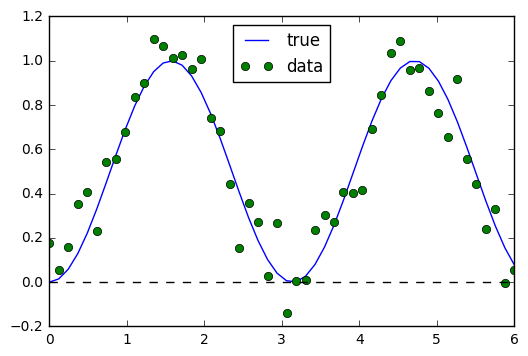

In [4]:
plt.plot(X1,f,'-', label='true')
plt.plot(X1,Y1,'o', label='data')
plt.plot([0,6],[0,0],'--k')
plt.legend(loc='best')

## 通常のGaussian Process

## Fit

In [5]:
model_gpr = GPflow.gpr.GPR(X1, Y1, 
                        kern=GPflow.kernels.RBF(1)) # RBF カーネルを使う

In [6]:
_ = model_gpr.optimize()

## 予測

In [7]:
X_new = np.linspace(-1,7,100)
f_pred = {}

In [8]:
f_mu, f_var= model_gpr.predict_f(X_new.reshape(-1,1))

In [9]:
f_pred['gpr'] = f_mu

In [10]:
f_pred['gpr_plus'] = f_mu.flatten() + 2*np.sqrt(f_var).flatten()
f_pred['gpr_minus']= f_mu.flatten() - 2*np.sqrt(f_var).flatten()

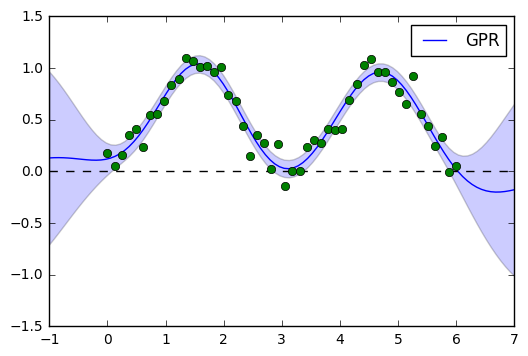

In [11]:
plt.fill_between(X_new, f_pred['gpr_plus'], f_pred['gpr_minus'], alpha=0.2)
plt.plot(X_new, f_pred['gpr'], label='GPR')
plt.plot([-1,7],[0,0],'--k')
plt.legend(loc='best')
plt.plot(X1, Y1, 'o')

### 解は正であるべきなのに、負の値も予測されている

### Exp() で隠れ関数を実データ領域にマップする

隠れ関数$g$を、ガウス過程に従う関数$f$に対して$g = \exp(f)$と変形する。

### 独自Likelihood を作る
https://github.com/GPflow/GPflow/blob/master/GPflow/likelihoods.py
のPoissonクラスを参考にする。
+ g = exp(f)
+ 尤度はガウス分布 $p(y|g) = \mathcal{N}(y|g, \sigma^2)$

In [12]:
import tensorflow as tf
from GPflow.likelihoods import Likelihood
from GPflow import densities, transforms
from GPflow.param import Param

class expGauss(GPflow.likelihoods.Likelihood):
    def __init__(self):
        GPflow.likelihoods.Likelihood.__init__(self)
        self.variance = Param(1.0, transforms.positive) # 正の分散パラメータを定義する

    def logp(self, F, Y):
        """
        logp(Y|F) を計算する。
        """
        return GPflow.densities.gaussian(
                    tf.exp(F),  # tensorflow の関数を使う。
                    Y,          # 
                    self.variance)


## model

In [13]:
model_vgp = GPflow.vgp.VGP(X1, Y1, 
                        kern=GPflow.kernels.RBF(1),
                        mean_function=GPflow.mean_functions.Constant(1), # 定数平均関数を使う（対数領域では正負の対称性がないため）
                        likelihood=expGauss()) # RBF カーネルを使う

### FIt

In [14]:
_ = model_vgp.optimize()

### 予測

In [15]:
f_mu, f_var= model_vgp.predict_f(X_new.reshape(-1,1))

In [17]:
f_pred['vgp'] = np.exp(f_mu)

In [18]:
f_pred['vgp_plus'] = np.exp(f_mu.flatten() + 2*np.sqrt(f_var).flatten())
f_pred['vgp_minus']= np.exp(f_mu.flatten() - 2*np.sqrt(f_var).flatten())

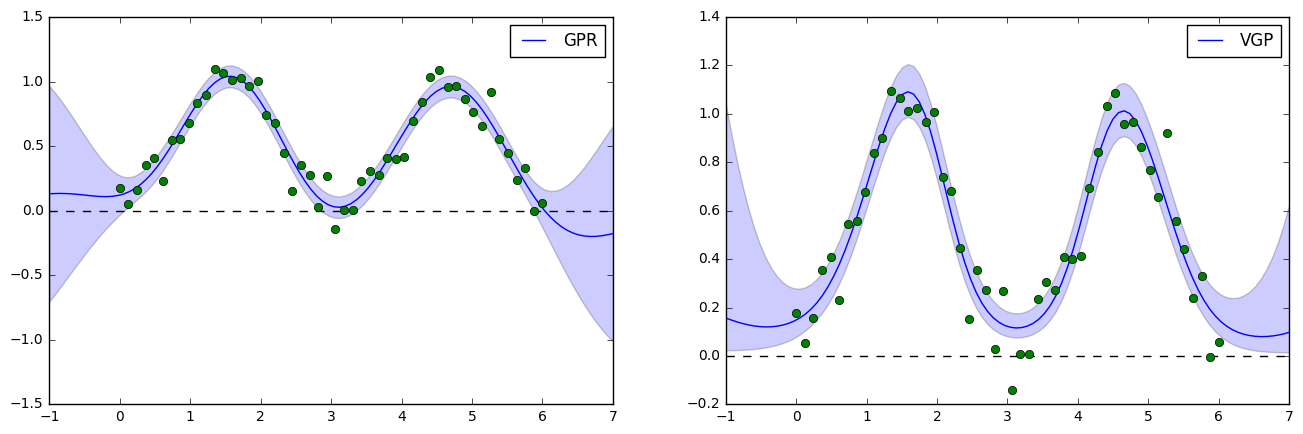

In [20]:
plt.figure(figsize=(16,5))
plt.subplot(1,2,1)
plt.fill_between(X_new, f_pred['gpr_plus'], f_pred['gpr_minus'], alpha=0.2)
plt.plot(X_new, f_pred['gpr'], label='GPR')
plt.plot([-1,7],[0,0],'--k')
plt.legend()
plt.plot(X1, Y1, 'o')
plt.subplot(1,2,2)
plt.fill_between(X_new, f_pred['vgp_plus'], f_pred['vgp_minus'], alpha=0.2)
plt.plot(X_new, f_pred['vgp'], label='VGP')
plt.plot([-1,7],[0,0],'--k')
plt.legend()
plt.plot(X1, Y1, 'o')

### コメント
変換を用いることで、正の領域に限った回帰ができる。